## MCS tracking GPM

This notebook tracks MCS in high resolution GPM data (30 min, 0.1 x 0.1 grid) based on contiguous precipitation pixels with a precipitation intensity, area and time persistence threshold

In [176]:
import numpy as np
import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy

import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

import pandas as pd 

In [221]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 


def create_dic():
    files={}
    keys=[]
    values=[]
    
    for year in np.arange(2014,2019,1):
        for month in np.arange(1,13,1):
            if month < 10:
                keys.append(str(year)+'0'+str(month))
            else:
                keys.append(str(year)+str(month))       

    for k in keys:
        values.append(glob.glob(working_dir + '3B-HHR.MS.MRG.3IMERG.' +  str(k) + '*.nc4'))

    ## populate dictionary with keys and values 
    files= dict(zip(keys, values))
    
    return files 


In [248]:
# This function reads in netcdf files and returns numpy arrays with precipitation for the specific time step and respective lon and lat grids
# returns also strings with date and time for respective timestep 

def read_in_netcdf(file, filename):
    date= filename[21:29]
    time= filename[31:35]
    dataset = Dataset(file)
    #print(dataset.variables.keys())
    
    time_slot= np.array(dataset["precipitationCal"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    # fill lat and lon values over entire grid 
    lons= np.repeat(np.expand_dims(lon, axis= 1), np.shape(lat)[0], axis= 1 )
    lats= np.repeat(np.expand_dims(lat, axis= 0), np.shape(lon)[0], axis= 0)
    dataset.close()

    return time_slot, lons, lats, date, time
    
    
    
    
    

In [139]:
# This function allows only for tracking in the actual TP boundaries, which means above 3000 m asl





In [140]:
## This function identifies MCS in one time slot based on a threshold rain rate and a threshold value for contiguous area
# returns following arrays for each time slot:
#  mcs : absolute rain rates 
#  mcs_labels: numbers assigned for each MCS 
# number_of_mcs: scalar containing the total number of detected mcs 

def mcs_identification(time_slot, threshold_prec, threshold_area, s ):
    
    prec_loc= np.where(time_slot > threshold_prec)
    ind_row= prec_loc[0]
    ind_col= prec_loc[1]

    im= time_slot
    im[ im < 7 ]=0
    potential_mcs, number_mcs = ndimage.label(im, structure = s) # array with nr. labels of contigous pixels above threshold and nr. of total identified MCS 

    x= potential_mcs[potential_mcs > 0 ]
    unique, counts = np.unique(x, return_counts=True)
    labels= np.asarray((unique, counts))[0]
    selection= np.asarray((unique, counts))[1] # np.array which contains all the assigned labels for areas which fulfill intensity threshold
    large = labels[selection > threshold_area]

    # create mask for pixel areas which fulfill area threshold 
    mask= np.isin(potential_mcs,large )
    # set all pixels which do not fulfill criteria to 0 in label matrix and rain rate matrix 
    potential_mcs[mask == False ]= 0
    time_slot[mask== False ]= 0 
    mcs = time_slot
    mcs_labels= potential_mcs
    # updated number of detected MCS 
    number_mcs = np.shape(np.unique(potential_mcs))[0]-1
    
    return mcs, mcs_labels, number_mcs 

In [141]:
# comparison between MCS identifications in both timeslots 
mcs_loc = np.nonzero(mcs_labels)
mcs_next_loc = np.nonzero(mcs_labels_next)
print('number MCS t1:  ', number_mcs, 'number MCS t2:  ', number_mcs_next)
print('number of potential MCS pixels:  ', np.shape(mcs_loc)[1], 'in next timestep: ', np.shape(mcs_next_loc)[1]  )
print('unique MCS labels t1:', np.unique(mcs_labels[mcs_labels > 0 ]), 'unique MCS labels t2:', np.unique(mcs_labels_next[mcs_labels_next > 0 ]) )

number MCS t1:   4 number MCS t2:   6
number of potential MCS pixels:   148 in next timestep:  198
unique MCS labels t1: [ 4  5 24 26] unique MCS labels t2: [ 1  5 19 25]


In [142]:
## This function compares identified MCS in the next step with MCS identified in the previous timestep
# and tracks the movement based on an overlap criterium 
# returns mcs_labels_next: updated array containing unique MCS labels (with same label for those pixel groups which have been identified belonging to the same system )


def update_labels(mcs_labels, mcs_labels_next):
    # set containing all labels with unique mcs identification numbers        
    all_mcs_labels = set(np.unique(mcs_labels[mcs_labels > 0])) #set.add 
    
    for idx, row in enumerate(mcs_labels_next):
        for col, val in enumerate(row):   
            if val > 0: # test for MCS in new time step        
                if mcs_labels[idx, col] > 0: # test if any of the pixels contains overlap 
                    mcs_labels_next[mcs_labels_next == val] = mcs_labels[idx, col] # assign old MCS label if group contains overlap 
                else:
                    new = 1 
                    new_label = range(1,1000)  # generate new identification nr if value already exists in set 
                    for i in new_label:
                        if i in all_mcs_labels:
                            new +=1           
                    if val in all_mcs_labels:
                        mcs_labels_next[mcs_labels_next == val] = new  # assign new MCS label for group without overlap 
                        all_mcs_labels.add(new) # add new generated value to set with all labels 
                        
    return mcs_labels_next                

In [236]:
## This function calculates and stores the lon and lat values of the system centers defined as the mean lon/lat of all
# pixels which belong to one identified system 
# returns dictionary with the number tags for each identied MCS as key values and corresponding lat and lon values 
    
    
def store_statistics(mcs_labels, date, time, system_stats, lats, lons, mcs):
    for i in np.unique(mcs_labels[mcs_labels > 0]):
        data = [str(i), str(date), str(time), np.mean(lats[mcs_labels == i ]) , np.mean(lons[mcs_labels == i ]), np.nanmean(mcs[ mcs_labels == i ]), np.nanmax(mcs[ mcs_labels == i ]), np.nanmin(mcs[ mcs_labels == i ]) ] 
        system_stats.loc[len(system_stats)] = data
        system_stats.date = system_stats.date.astype(str)
        system_stats.time = system_stats.time.astype(str)
        
    return system_stats

In [331]:
## This function saves the creates pandas dataframe with all detected MCS tracks within one month to a netcdf file 

def create_netcdf(system_stats, output_path):
    data_as_xr= system_stats.to_xarray()
    data_as_xr.to_netcdf(output_path, mode = 'w', format='NETCDF4', unlimited_dims=['ID']) 


## Main program 

In [337]:
## Initialization 

# thresholds 
threshold_prec= 7 # rain rate mm/hr 
threshold_area= 10 # number of contigous pixels
threshold_timesteps= 6 #6 timesteps = 3 hr 
threshold_overlap = 1 # number of pixels for overlap 
s = generate_binary_structure(2,2) # structure element which defined what type of connections are allowed in cluster finding,here: diagonal connections 

# create empty pandas dataframe 
stats= ['ID', 'date', 'time', 'lon', 'lat', 'PREC_mean', 'PREC_max', 'PREC_min']
system_stats = pd.DataFrame(columns=stats)

# set working directory 
working_dir= '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/' 


In [ ]:
# call function to create dictionary with all files for one month 
files = create_dic() 

In [270]:
##################################### TEST WITH ONE FILE ###############################################################

filename= '3B-HHR.MS.MRG.3IMERG.20180630-S230000-E232959.1380.V05B.HDF5.nc4'
file= working_dir + filename


# read in first netcdf file
time_slot, lons, lats, date, time = read_in_netcdf(file, filename)
# identify MCS in first netcdf file 
mcs, mcs_labels, number_mcs= mcs_identification(time_slot,threshold_prec,threshold_area, s)
# update MCS statistics 
system_stats = store_statistics(mcs_labels, date, time, system_stats, lats, lons, mcs)

# read in next timestep 
filename_next= '3B-HHR.MS.MRG.3IMERG.20180630-S233000-E235959.1410.V05B.HDF5.nc4'
file_next= working_dir + filename_next
time_slot_next, lons__next, lats_next, date, time = read_in_netcdf(file_next, filename_next)
# identify MCS in next timestep 
mcs_next, mcs_labels_next, number_mcs_next = mcs_identification(time_slot_next,threshold_prec,threshold_area, s)
# compare MCS to next timestep and track systems with overlap (through assigning same label)
mcs_labels_next = update_labels(mcs_labels, mcs_labels_next)
# update MCS statistics 
system_stats = store_statistics(mcs_labels_next, date, time, system_stats, lats, lons, mcs_next)





In [338]:
## loop through all hourly files within one month 

month = '201804'
i = 0 

for file in files[month]:
    if i == 0: 
        filename = file[50::]
        # read in first netcdf file
        time_slot, lons, lats, date, time = read_in_netcdf(file, filename)
        # identify MCS in first netcdf file 
        mcs, mcs_labels, number_mcs= mcs_identification(time_slot,threshold_prec,threshold_area, s)
        # update MCS statistics 
        system_stats = store_statistics(mcs_labels, date, time, system_stats, lats, lons, mcs)
        print(file, filename, system_stats.shape)
        
    while i < np.shape(files[month])[0]-1:
        # read in next timestep 
        file_next= files[month][i+1]
        filename_next = file_next[50::]
        print(file_next, filename_next, system_stats.shape)
        time_slot_next, lons__next, lats_next, date, time = read_in_netcdf(file_next, filename_next)
        # identify MCS in next timestep 
        mcs_next, mcs_labels_next, number_mcs_next = mcs_identification(time_slot_next,threshold_prec,threshold_area, s)
        # compare MCS to next timestep and track systems with overlap (through assigning same label)
        mcs_labels_next = update_labels(mcs_labels, mcs_labels_next)
        # update MCS statistics 
        system_stats = store_statistics(mcs_labels_next, date, time, system_stats, lats, lons, mcs_next)

        # control that next file is openenend and open labels become the MCS labels from previous timestep to compare with 
        i += 1 
        mcs_labels = mcs_labels_next 


system_stats = system_stats.set_index('ID')
system_stats = system_stats.sort_index(axis = 0)
output_path= working_dir + '/tracks/'+   date[0:6]+ '_' + 'tracks.nc'
create_netcdf(system_stats, output_path)    
    

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180401-S000000-E002959.0000.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180401-S000000-E002959.0000.V05B.HDF5.nc4 (2, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180401-S010000-E012959.0060.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180401-S010000-E012959.0060.V05B.HDF5.nc4 (2, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180401-S013000-E015959.0090.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180401-S013000-E015959.0090.V05B.HDF5.nc4 (2, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180401-S020000-E022959.0120.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180401-S020000-E022959.0120.V05B.HDF5.nc4 (2, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180401-S023000-E025959.0150.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180401-S023000-E025959.0150.V05B.HDF5.nc4 (2, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180402-S000000-E002959.0000.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180402-S000000-E002959.0000.V05B.HDF5.nc4 (21, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180402-S003000-E005959.0030.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180402-S003000-E005959.0030.V05B.HDF5.nc4 (21, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180402-S010000-E012959.0060.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180402-S010000-E012959.0060.V05B.HDF5.nc4 (23, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180402-S020000-E022959.0120.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180402-S020000-E022959.0120.V05B.HDF5.nc4 (23, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180402-S023000-E025959.0150.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180402-S023000-E025959.0150.V05B.HDF5.nc4 (23, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S003000-E005959.0030.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S003000-E005959.0030.V05B.HDF5.nc4 (42, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S010000-E012959.0060.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S010000-E012959.0060.V05B.HDF5.nc4 (42, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S013000-E015959.0090.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S013000-E015959.0090.V05B.HDF5.nc4 (43, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S020000-E022959.0120.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S020000-E022959.0120.V05B.HDF5.nc4 (44, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S030000-E032959.0180.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S030000-E032959.0180.V05B.HDF5.nc4 (44, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S210000-E212959.1260.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S210000-E212959.1260.V05B.HDF5.nc4 (54, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S213000-E215959.1290.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S213000-E215959.1290.V05B.HDF5.nc4 (54, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S220000-E222959.1320.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S220000-E222959.1320.V05B.HDF5.nc4 (54, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S230000-E232959.1380.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S230000-E232959.1380.V05B.HDF5.nc4 (54, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180403-S233000-E235959.1410.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180403-S233000-E235959.1410.V05B.HDF5.nc4 (54, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180404-S220000-E222959.1320.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180404-S220000-E222959.1320.V05B.HDF5.nc4 (80, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180404-S223000-E225959.1350.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180404-S223000-E225959.1350.V05B.HDF5.nc4 (81, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180404-S230000-E232959.1380.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180404-S230000-E232959.1380.V05B.HDF5.nc4 (82, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180405-S000000-E002959.0000.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180405-S000000-E002959.0000.V05B.HDF5.nc4 (84, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180405-S003000-E005959.0030.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180405-S003000-E005959.0030.V05B.HDF5.nc4 (84, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180405-S183000-E185959.1110.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180405-S183000-E185959.1110.V05B.HDF5.nc4 (103, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180405-S190000-E192959.1140.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180405-S190000-E192959.1140.V05B.HDF5.nc4 (103, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180405-S200000-E202959.1200.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180405-S200000-E202959.1200.V05B.HDF5.nc4 (103, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180405-S203000-E205959.1230.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180405-S203000-E205959.1230.V05B.HDF5.nc4 (103, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180405-S210000-E212959.1260.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180405-S210000-E212959.1260.V05B.HDF5.nc4 (103, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180406-S193000-E195959.1170.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180406-S193000-E195959.1170.V05B.HDF5.nc4 (130, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180406-S200000-E202959.1200.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180406-S200000-E202959.1200.V05B.HDF5.nc4 (131, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180406-S210000-E212959.1260.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180406-S210000-E212959.1260.V05B.HDF5.nc4 (132, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180406-S213000-E215959.1290.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180406-S213000-E215959.1290.V05B.HDF5.nc4 (133, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180406-S220000-E222959.1320.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180406-S220000-E222959.1320.V05B.HDF5.nc4 (134, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180407-S150000-E152959.0900.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180407-S150000-E152959.0900.V05B.HDF5.nc4 (162, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180407-S153000-E155959.0930.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180407-S153000-E155959.0930.V05B.HDF5.nc4 (162, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180407-S160000-E162959.0960.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180407-S160000-E162959.0960.V05B.HDF5.nc4 (162, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180407-S170000-E172959.1020.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180407-S170000-E172959.1020.V05B.HDF5.nc4 (162, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180407-S173000-E175959.1050.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180407-S173000-E175959.1050.V05B.HDF5.nc4 (163, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180408-S160000-E162959.0960.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180408-S160000-E162959.0960.V05B.HDF5.nc4 (189, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180408-S163000-E165959.0990.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180408-S163000-E165959.0990.V05B.HDF5.nc4 (190, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180408-S170000-E172959.1020.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180408-S170000-E172959.1020.V05B.HDF5.nc4 (191, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180408-S180000-E182959.1080.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180408-S180000-E182959.1080.V05B.HDF5.nc4 (192, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180408-S183000-E185959.1110.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180408-S183000-E185959.1110.V05B.HDF5.nc4 (193, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180409-S123000-E125959.0750.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180409-S123000-E125959.0750.V05B.HDF5.nc4 (222, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180409-S130000-E132959.0780.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180409-S130000-E132959.0780.V05B.HDF5.nc4 (223, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180409-S140000-E142959.0840.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180409-S140000-E142959.0840.V05B.HDF5.nc4 (225, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180409-S143000-E145959.0870.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180409-S143000-E145959.0870.V05B.HDF5.nc4 (226, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180409-S150000-E152959.0900.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180409-S150000-E152959.0900.V05B.HDF5.nc4 (227, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180410-S133000-E135959.0810.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180410-S133000-E135959.0810.V05B.HDF5.nc4 (235, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180410-S140000-E142959.0840.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180410-S140000-E142959.0840.V05B.HDF5.nc4 (236, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180410-S150000-E152959.0900.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180410-S150000-E152959.0900.V05B.HDF5.nc4 (238, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180410-S153000-E155959.0930.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180410-S153000-E155959.0930.V05B.HDF5.nc4 (238, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180410-S160000-E162959.0960.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180410-S160000-E162959.0960.V05B.HDF5.nc4 (238, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180411-S100000-E102959.0600.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180411-S100000-E102959.0600.V05B.HDF5.nc4 (268, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180411-S110000-E112959.0660.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180411-S110000-E112959.0660.V05B.HDF5.nc4 (271, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180411-S113000-E115959.0690.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180411-S113000-E115959.0690.V05B.HDF5.nc4 (273, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180411-S120000-E122959.0720.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180411-S120000-E122959.0720.V05B.HDF5.nc4 (274, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180411-S123000-E125959.0750.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180411-S123000-E125959.0750.V05B.HDF5.nc4 (274, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180412-S110000-E112959.0660.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180412-S110000-E112959.0660.V05B.HDF5.nc4 (290, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180412-S120000-E122959.0720.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180412-S120000-E122959.0720.V05B.HDF5.nc4 (290, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180412-S123000-E125959.0750.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180412-S123000-E125959.0750.V05B.HDF5.nc4 (292, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180412-S130000-E132959.0780.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180412-S130000-E132959.0780.V05B.HDF5.nc4 (294, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180412-S133000-E135959.0810.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180412-S133000-E135959.0810.V05B.HDF5.nc4 (295, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180413-S080000-E082959.0480.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180413-S080000-E082959.0480.V05B.HDF5.nc4 (322, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180413-S083000-E085959.0510.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180413-S083000-E085959.0510.V05B.HDF5.nc4 (322, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180413-S090000-E092959.0540.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180413-S090000-E092959.0540.V05B.HDF5.nc4 (322, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180413-S093000-E095959.0570.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180413-S093000-E095959.0570.V05B.HDF5.nc4 (323, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180413-S100000-E102959.0600.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180413-S100000-E102959.0600.V05B.HDF5.nc4 (323, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180414-S090000-E092959.0540.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180414-S090000-E092959.0540.V05B.HDF5.nc4 (344, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180414-S093000-E095959.0570.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180414-S093000-E095959.0570.V05B.HDF5.nc4 (344, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180414-S100000-E102959.0600.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180414-S100000-E102959.0600.V05B.HDF5.nc4 (344, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180414-S103000-E105959.0630.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180414-S103000-E105959.0630.V05B.HDF5.nc4 (344, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180414-S110000-E112959.0660.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180414-S110000-E112959.0660.V05B.HDF5.nc4 (344, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180415-S053000-E055959.0330.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180415-S053000-E055959.0330.V05B.HDF5.nc4 (386, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180415-S060000-E062959.0360.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180415-S060000-E062959.0360.V05B.HDF5.nc4 (387, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180415-S063000-E065959.0390.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180415-S063000-E065959.0390.V05B.HDF5.nc4 (387, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180415-S070000-E072959.0420.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180415-S070000-E072959.0420.V05B.HDF5.nc4 (387, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180415-S073000-E075959.0450.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180415-S073000-E075959.0450.V05B.HDF5.nc4 (387, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180416-S063000-E065959.0390.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180416-S063000-E065959.0390.V05B.HDF5.nc4 (403, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180416-S070000-E072959.0420.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180416-S070000-E072959.0420.V05B.HDF5.nc4 (404, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180416-S073000-E075959.0450.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180416-S073000-E075959.0450.V05B.HDF5.nc4 (404, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180416-S080000-E082959.0480.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180416-S080000-E082959.0480.V05B.HDF5.nc4 (405, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180416-S083000-E085959.0510.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180416-S083000-E085959.0510.V05B.HDF5.nc4 (406, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180417-S030000-E032959.0180.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180417-S030000-E032959.0180.V05B.HDF5.nc4 (428, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180417-S033000-E035959.0210.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180417-S033000-E035959.0210.V05B.HDF5.nc4 (428, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180417-S040000-E042959.0240.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180417-S040000-E042959.0240.V05B.HDF5.nc4 (428, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180417-S043000-E045959.0270.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180417-S043000-E045959.0270.V05B.HDF5.nc4 (428, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180417-S050000-E052959.0300.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180417-S050000-E052959.0300.V05B.HDF5.nc4 (428, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180418-S040000-E042959.0240.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180418-S040000-E042959.0240.V05B.HDF5.nc4 (442, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180418-S043000-E045959.0270.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180418-S043000-E045959.0270.V05B.HDF5.nc4 (442, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180418-S050000-E052959.0300.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180418-S050000-E052959.0300.V05B.HDF5.nc4 (442, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180418-S053000-E055959.0330.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180418-S053000-E055959.0330.V05B.HDF5.nc4 (442, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180418-S060000-E062959.0360.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180418-S060000-E062959.0360.V05B.HDF5.nc4 (442, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180419-S003000-E005959.0030.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180419-S003000-E005959.0030.V05B.HDF5.nc4 (466, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180419-S010000-E012959.0060.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180419-S010000-E012959.0060.V05B.HDF5.nc4 (466, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180419-S013000-E015959.0090.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180419-S013000-E015959.0090.V05B.HDF5.nc4 (466, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180419-S020000-E022959.0120.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180419-S020000-E022959.0120.V05B.HDF5.nc4 (466, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180419-S023000-E025959.0150.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180419-S023000-E025959.0150.V05B.HDF5.nc4 (466, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S013000-E015959.0090.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S013000-E015959.0090.V05B.HDF5.nc4 (491, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S020000-E022959.0120.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S020000-E022959.0120.V05B.HDF5.nc4 (492, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S023000-E025959.0150.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S023000-E025959.0150.V05B.HDF5.nc4 (494, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S030000-E032959.0180.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S030000-E032959.0180.V05B.HDF5.nc4 (496, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S033000-E035959.0210.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S033000-E035959.0210.V05B.HDF5.nc4 (498, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S220000-E222959.1320.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S220000-E222959.1320.V05B.HDF5.nc4 (541, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S223000-E225959.1350.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S223000-E225959.1350.V05B.HDF5.nc4 (542, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S230000-E232959.1380.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S230000-E232959.1380.V05B.HDF5.nc4 (542, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180420-S233000-E235959.1410.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180420-S233000-E235959.1410.V05B.HDF5.nc4 (543, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180421-S000000-E002959.0000.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180421-S000000-E002959.0000.V05B.HDF5.nc4 (545, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180421-S230000-E232959.1380.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180421-S230000-E232959.1380.V05B.HDF5.nc4 (558, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180421-S233000-E235959.1410.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180421-S233000-E235959.1410.V05B.HDF5.nc4 (558, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S000000-E002959.0000.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S000000-E002959.0000.V05B.HDF5.nc4 (558, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S003000-E005959.0030.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S003000-E005959.0030.V05B.HDF5.nc4 (558, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S010000-E012959.0060.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S010000-E012959.0060.V05B.HDF5.nc4 (558, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S193000-E195959.1170.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S193000-E195959.1170.V05B.HDF5.nc4 (581, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S200000-E202959.1200.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S200000-E202959.1200.V05B.HDF5.nc4 (581, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S203000-E205959.1230.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S203000-E205959.1230.V05B.HDF5.nc4 (581, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S210000-E212959.1260.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S210000-E212959.1260.V05B.HDF5.nc4 (581, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S220000-E222959.1320.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S220000-E222959.1320.V05B.HDF5.nc4 (581, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180423-S203000-E205959.1230.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180423-S203000-E205959.1230.V05B.HDF5.nc4 (582, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180423-S210000-E212959.1260.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180423-S210000-E212959.1260.V05B.HDF5.nc4 (582, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180423-S213000-E215959.1290.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180423-S213000-E215959.1290.V05B.HDF5.nc4 (582, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180423-S220000-E222959.1320.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180423-S220000-E222959.1320.V05B.HDF5.nc4 (582, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180422-S013000-E015959.0090.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180422-S013000-E015959.0090.V05B.HDF5.nc4 (582, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180424-S123000-E125959.0750.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180424-S123000-E125959.0750.V05B.HDF5.nc4 (586, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180424-S130000-E132959.0780.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180424-S130000-E132959.0780.V05B.HDF5.nc4 (586, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180424-S140000-E142959.0840.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180424-S140000-E142959.0840.V05B.HDF5.nc4 (586, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180424-S143000-E145959.0870.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180424-S143000-E145959.0870.V05B.HDF5.nc4 (586, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180424-S150000-E152959.0900.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180424-S150000-E152959.0900.V05B.HDF5.nc4 (586, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180425-S133000-E135959.0810.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180425-S133000-E135959.0810.V05B.HDF5.nc4 (597, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180425-S140000-E142959.0840.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180425-S140000-E142959.0840.V05B.HDF5.nc4 (597, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180425-S150000-E152959.0900.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180425-S150000-E152959.0900.V05B.HDF5.nc4 (597, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180425-S153000-E155959.0930.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180425-S153000-E155959.0930.V05B.HDF5.nc4 (598, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180425-S160000-E162959.0960.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180425-S160000-E162959.0960.V05B.HDF5.nc4 (599, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180426-S100000-E102959.0600.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180426-S100000-E102959.0600.V05B.HDF5.nc4 (606, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180426-S110000-E112959.0660.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180426-S110000-E112959.0660.V05B.HDF5.nc4 (607, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180426-S113000-E115959.0690.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180426-S113000-E115959.0690.V05B.HDF5.nc4 (607, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180426-S120000-E122959.0720.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180426-S120000-E122959.0720.V05B.HDF5.nc4 (608, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180426-S123000-E125959.0750.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180426-S123000-E125959.0750.V05B.HDF5.nc4 (608, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180427-S110000-E112959.0660.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180427-S110000-E112959.0660.V05B.HDF5.nc4 (612, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180427-S120000-E122959.0720.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180427-S120000-E122959.0720.V05B.HDF5.nc4 (612, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180427-S123000-E125959.0750.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180427-S123000-E125959.0750.V05B.HDF5.nc4 (612, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180427-S130000-E132959.0780.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180427-S130000-E132959.0780.V05B.HDF5.nc4 (612, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180427-S133000-E135959.0810.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180427-S133000-E135959.0810.V05B.HDF5.nc4 (612, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180428-S080000-E082959.0480.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180428-S080000-E082959.0480.V05B.HDF5.nc4 (616, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180428-S083000-E085959.0510.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180428-S083000-E085959.0510.V05B.HDF5.nc4 (616, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180428-S090000-E092959.0540.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180428-S090000-E092959.0540.V05B.HDF5.nc4 (616, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180428-S093000-E095959.0570.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180428-S093000-E095959.0570.V05B.HDF5.nc4 (616, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180428-S100000-E102959.0600.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180428-S100000-E102959.0600.V05B.HDF5.nc4 (616, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180429-S090000-E092959.0540.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180429-S090000-E092959.0540.V05B.HDF5.nc4 (625, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180429-S093000-E095959.0570.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180429-S093000-E095959.0570.V05B.HDF5.nc4 (627, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180429-S100000-E102959.0600.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180429-S100000-E102959.0600.V05B.HDF5.nc4 (628, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180429-S103000-E105959.0630.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180429-S103000-E105959.0630.V05B.HDF5.nc4 (629, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180429-S110000-E112959.0660.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180429-S110000-E112959.0660.V05B.HDF5.nc4 (630, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180430-S053000-E055959.0330.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180430-S053000-E055959.0330.V05B.HDF5.nc4 (661, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180430-S060000-E062959.0360.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180430-S060000-E062959.0360.V05B.HDF5.nc4 (662, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180430-S063000-E065959.0390.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180430-S063000-E065959.0390.V05B.HDF5.nc4 (663, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180430-S070000-E072959.0420.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180430-S070000-E072959.0420.V05B.HDF5.nc4 (664, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180430-S073000-E075959.0450.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180430-S073000-E075959.0450.V05B.HDF5.nc4 (664, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HH

/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180429-S083000-E085959.0510.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180429-S083000-E085959.0510.V05B.HDF5.nc4 (688, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180404-S233000-E235959.1410.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180404-S233000-E235959.1410.V05B.HDF5.nc4 (688, 8)
/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/3B-HHR.MS.MRG.3IMERG.20180421-S203000-E205959.1230.V05B.HDF5.nc4 3B-HHR.MS.MRG.3IMERG.20180421-S203000-E205959.1230.V05B.HDF5.nc4 (690, 8)


TypeError: create_netcdf() missing 1 required positional argument: 'output_path'

In [351]:
system_stats = system_stats.sort_index(axis = 0)

In [352]:
system_stats

,date,time,lon,lat,PREC_mean,PREC_max,PREC_min
ID,,,,,,,
1,20180401,0000,41.783333,70.650002,12.389207,20.400305,7.008123
1,20180416,1930,38.861107,70.866669,15.676956,29.171061,7.129929
1,20180417,1230,33.604546,71.122726,16.554792,43.495392,7.640298
1,20180417,1800,36.662498,70.906250,12.137147,19.140806,7.366531
1,20180418,1300,34.301517,71.580307,14.100379,30.851221,7.249077
1,20180420,0000,32.822727,71.777275,8.521067,10.696525,7.416173
1,20180420,0100,33.424999,71.919998,14.077108,35.955654,7.165927
1,20180420,0130,33.434212,71.897369,11.274010,16.928167,8.038212
1,20180420,0200,33.395451,71.881821,9.812577,13.981696,7.039218


In [354]:
for month in files.keys():

    

SyntaxError: unexpected EOF while parsing (<ipython-input-354-045923c5418c>, line 3)

## Todo 


- loop over ALL files (based on monthly keys in dictionary) 

- date and time as string in netcdf files 

- change threshholds! (right now too loose, "cyclone" for several days) 

- sort after both ID, date and time! 



- function to extract only pixels over 3000 m 

- sensitivity tests for threshold 

- update plot functions

- make the code running for GPM, MSWEP and CNRR (maybe via class identification?) 

- function to track in case MCS divides in multiple cells (more advanced tracking in addition to overlap)

## Plots 

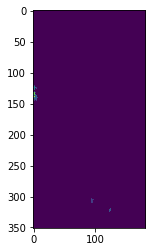

In [122]:
# quick plot precipitation 

plt.imshow(mcs)
plt.show()


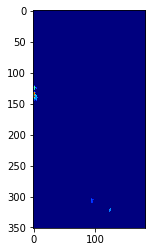

In [123]:
# quick plot identified MCS 

plt.imshow(time_slot, cmap=plt.cm.jet)
plt.show()
